<a href="https://colab.research.google.com/github/jayshree346/stock_price_prediction/blob/main/Multivariate_analysis_2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print(sys.version)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [ ]:
# Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2) 
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense,Dropout
from keras.layers.recurrent import LSTM,GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing

In [ ]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/GOOG (1).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [ ]:
df['Date']= pd.to_datetime(df['Date'])

In [ ]:
df.shape

(4127, 7)

In [ ]:
# df.set_index("Date",inplace=True)
df = df.iloc[:4122,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4117,2020-12-24,1735.000000,1746.000000,1729.109985,1738.849976,1738.849976,346800
4118,2020-12-28,1751.635010,1790.728027,1746.334961,1776.089966,1776.089966,1393000
4119,2020-12-29,1787.790039,1792.439941,1756.089966,1758.719971,1758.719971,1299400
4120,2020-12-30,1762.010010,1765.094971,1725.599976,1739.520020,1739.520020,1306100
4121,2020-12-31,1735.420044,1758.930054,1735.420044,1751.880005,1751.880005,1011900


In [ ]:
# Correlation matrix
df.corr()['Adj Close']

Open         0.999752
High         0.999868
Low          0.999889
Close        1.000000
Adj Close    1.000000
Volume      -0.531981
Name: Adj Close, dtype: float64

In [ ]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.122000e+03
mean     6.770436e+06
std      7.928326e+06
min      7.900000e+03
25%      1.689025e+06
50%      4.075300e+06
75%      8.665350e+06
max      8.254150e+07
Name: Volume, dtype: float64


In [ ]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(len(train)-timesteps-1):
        X_train.append(train[i:i+timesteps,:])
        Y_train.append(train[i+timesteps,:])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 3)
    print('shape os X_train and Y_train', X_train.shape,Y_train.shape)
  
    # Loop for val data
    for i in range(len(val)-timesteps-1):
        X_val.append(val[i:i+timesteps,:])
        Y_val.append(val[i+timesteps,:])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 3)
    print('shape of validation set', X_val.shape,Y_val.shape)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(units=50,input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,activation='relu'))
    model.add(Dropout(0.2))
    # model.add(GRU(units=50,return_sequences = True,activation='relu'))
    # model.add(Dropout(0.2))        
    # model.add(LSTM(units=50,activation='relu',return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(GRU(units=50,return_sequences = True,activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(50, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=50,activation='relu'))
    model.add(Dense(3))
    model.compile(optimizer = 'adamax', loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [ ]:
#model.summary()

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(len(test)-timesteps-1):
        X_test.append(test[i:i+timesteps,:])
        Y_test.append(test[i+timesteps,:])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    X_test =X_test.reshape(X_test.shape[0],X_test.shape[1] , 3)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    Y_hat = sc.inverse_transform(Y_hat)
    Y_test = sc.inverse_transform(Y_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat,multioutput='uniform_average')
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'y')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Model Building

In [ ]:
# Extracting the series
series = df[['Date','Adj Close','High','Low']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(4122, 4)
           Date    Adj Close         High          Low
4117 2020-12-24  1738.849976  1746.000000  1729.109985
4118 2020-12-28  1776.089966  1790.728027  1746.334961
4119 2020-12-29  1758.719971  1792.439941  1756.089966
4120 2020-12-30  1739.520020  1765.094971  1725.599976
4121 2020-12-31  1751.880005  1758.930054  1735.420044


In [ ]:
# Train Val Test Split
sert = series[series['Date'] <= '2019-12-31']
serte = series[(series['Date'] > '2019-12-31')]
sert.shape,serte.shape
# val_data = series.loc[151:201]
# test_data = series.loc[202:250]
# print(train_data.shape,val_data.shape,test_data.shape)


((3869, 4), (253, 4))

In [ ]:
# Normalisation
sc = MinMaxScaler()
series_sc = sc.fit_transform(sert.drop(['Date'],axis=1))
series_sc_te = sc.fit_transform(serte.drop(['Date'],axis=1))
# series_sc = np.column_stack((series_sc,temp))
print(series_sc.shape)
print(series_sc_te.shape)

(3869, 3)
(253, 3)


In [ ]:
train_size=int(len(sert)*0.8)
train_data = series_sc[:train_size]

val_size = int((len(sert)*0.2)+train_size)
val_data = series_sc[train_size:val_size+1]

test_data = series_sc_te[:]

print(train_data.shape,val_data.shape,test_data.shape)


(3095, 3) (774, 3) (253, 3)


In [ ]:
timesteps = 2
batch_size = None
num_epochs = 20

shape os X_train and Y_train (3092, 2, 3) (3092, 3)
shape of validation set (771, 2, 3) (771, 3)
Epoch 1/20
97/97 [==============================] - 5s 18ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 2/20
97/97 [==============================] - 1s 13ms/step - loss: 0.0179 - val_loss: 0.0010
Epoch 3/20
97/97 [==============================] - 1s 12ms/step - loss: 0.0135 - val_loss: 3.0961e-04
Epoch 4/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0068 - val_loss: 3.7990e-04
Epoch 5/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0037 - val_loss: 5.4859e-04
Epoch 6/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0024 - val_loss: 6.4873e-04
Epoch 7/20
97/97 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.9060e-04
Epoch 8/20
97/97 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 8.1642e-04
Epoch 9/20
97/97 [==============================] - 1s 12ms/step - loss: 7.9462e-04 - v

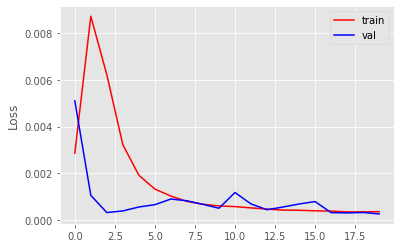

In [ ]:
model,train_error,val_error = fit_model(train_data,val_data,timesteps,batch_size,num_epochs)
plot_error(train_error,val_error)

In [ ]:
mse, rmse, r2_value,true_train,train_predict = evaluate_model(model,train_data,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

MSE = 37.95662414805124
RMSE = 6.160894752229683
R-Squared Score = 0.9968918648902448


In [ ]:
true_train

array([[1059.37139837, 1074.77223195, 1017.57923157],
       [1058.04404379, 1074.21939618, 1015.88657708],
       [1058.37515156, 1073.16077379, 1015.98233059],
       ...,
       [1479.21366532, 1501.58057584, 1455.02737997],
       [1480.74307228, 1500.97252078, 1460.26079633],
       [1473.21376252, 1497.71980705, 1451.94563573]])

In [ ]:
mse, rmse, r2_value,true_test,test_predict = evaluate_model(model,test_data,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

MSE = 1148.2723469975542
RMSE = 33.88616748759816
R-Squared Score = 0.9630521288735525


In [ ]:
model.save('Stock_Pred.h5')

In [ ]:
temp = pd.DataFrame(true_test,columns=['Adj Close','High','Low'])
temp2 = pd.DataFrame(test_predict,columns=['Adj Close','High','Low'])

In [ ]:
visualize = pd.concat([temp,temp2],axis=1)
visualize

,Adj Close,High,Low,Adj Close,High,Low
0,1394.209961,1396.500000,1350.000000,1361.458374,1379.434204,1330.884766
1,1393.339966,1402.989990,1390.380005,1369.374512,1387.335449,1338.996948
2,1404.319946,1411.579956,1390.839966,1387.087891,1405.288452,1357.367676
3,1419.829956,1427.329956,1410.270020,1397.579346,1415.992554,1368.350830
4,1429.729980,1434.928955,1418.349976,1407.773560,1426.213135,1378.809326
...,...,...,...,...,...,...
245,1732.380005,1747.989990,1725.040039,1731.579468,1741.916016,1706.211304
246,1738.849976,1746.000000,1729.109985,1734.009277,1744.142090,1708.461426
247,1776.089966,1790.728027,1746.334961,1742.092896,1751.871338,1716.600830
248,1758.719971,1792.439941,1756.089966,1757.889893,1766.668579,1731.811035


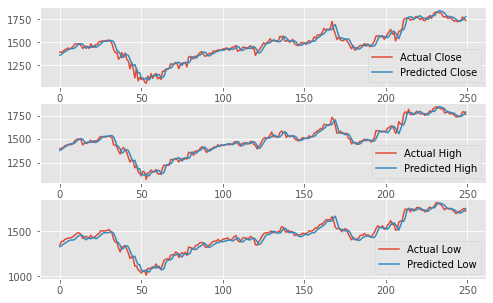

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Stock prediction")
plt.subplot(3,1,1)
plt.plot(temp['Adj Close'],label='Actual Close')
plt.plot(temp2['Adj Close'],label='Predicted Close')
plt.legend()
plt.subplot(3,1,2)
plt.plot(temp['High'],label='Actual High')
plt.plot(temp2['High'],label='Predicted High')
plt.legend()
plt.subplot(3,1,3)
plt.plot(temp['Low'],label='Actual Low')
plt.plot(temp2['Low'],label='Predicted Low')
plt.legend()

In [ ]:
# train_predict=sc.inverse_transform(train_predicted)
# test_predict=sc.inverse_transform(test_predicted)

In [ ]:
test_data = test_data[:,np.newaxis]
test_data.shape

(1, 1, 253, 1, 1, 3)

In [ ]:
day_ahead = 30
for step_ahead in the range(day_ahead):
  y_pred_one = model.predict(test_data[:,steap_ahead:])